<a href="https://colab.research.google.com/github/Lenferd/pcam_train/blob/lab5-optimize-train-param/lab-5-learning-transfer/pcam_lab_5_densnet_retrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keras imports

In [0]:
import os
import tensorflow as tf
import numpy as np
%pip install keras-metrics
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Load dataset

In [0]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/DL_PCAM')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
train_x_name = 'camelyonpatch_level_2_split_train_x.h5'
train_y_name = 'camelyonpatch_level_2_split_train_y.h5'

test_x_name = 'camelyonpatch_level_2_split_test_x.h5'
test_y_name = 'camelyonpatch_level_2_split_test_y.h5'

valid_x_name = 'camelyonpatch_level_2_split_valid_x.h5'
valid_y_name = 'camelyonpatch_level_2_split_valid_y.h5'

meta_train_name = 'camelyonpatch_level_2_split_train_meta.csv'
meta_valid_name = 'camelyonpatch_level_2_split_valid_meta.csv'
meta_test_name  = 'camelyonpatch_level_2_split_test_meta.csv'

In [0]:
from keras.utils import HDF5Matrix, normalize

x_train = HDF5Matrix(train_x_name, 'x', 
                     normalizer=lambda x: np.true_divide(x, 255.))
y_train = HDF5Matrix(train_y_name, 'y')

x_valid = HDF5Matrix(valid_x_name, 'x', 
                     normalizer=lambda x: np.true_divide(x, 255.))
y_valid = HDF5Matrix(valid_y_name, 'y')

x_test  = HDF5Matrix(test_x_name, 'x', 
                     normalizer=lambda x: np.true_divide(x, 255.))
y_test  = HDF5Matrix(test_y_name, 'y')

Using TensorFlow backend.


# Reshape labels

In [0]:
# Input image dimensions.
input_shape = x_train.shape[1:]

y_train = np.array(y_train)
y_train = y_train.reshape((y_train.shape[0], 1))

y_valid = np.array(y_valid)
y_valid = y_valid.reshape((y_valid.shape[0], 1))

y_test = np.array(y_test)
y_test = y_test.reshape((y_test.shape[0], 1))

print('input share:', input_shape)
print('x_train shape:', x_train.shape)

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

input share: (96, 96, 3)
x_train shape: (262144, 96, 96, 3)
262144 train samples
32768 test samples
y_train shape: (262144, 1)


In [0]:
y_train = y_train.reshape((y_train.shape[0], 1))
print("1 in train : {}".format(np.count_nonzero(y_train == 1)))
print("0 in train : {}".format(np.count_nonzero(y_train == 0)))

y_valid = y_valid.reshape((y_valid.shape[0], 1))
print("1 in valid : {}".format(np.count_nonzero(y_valid == 1)))
print("0 in valid : {}".format(np.count_nonzero(y_valid == 0)))

1 in train : 131072
0 in train : 131072
1 in valid : 16369
0 in valid : 16399


# Prepare Densnet121 model

In [0]:
from keras.applications.densenet import DenseNet121
from keras.models import Sequential
from keras import layers

def denseNet_trained(input_shape, num_classes=1):
  densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
  model = Sequential()
  model.add(densenet_model)
  model.add(layers.GlobalAveragePooling2D())
  model.add(layers.Dense(1, activation='sigmoid', name='fc1', kernel_initializer = 'he_normal'))
  return model

In [0]:
model = denseNet_trained(input_shape)














29089792/29084464 [==============================] - 3s 0us/step



## Densnet info

### Summary

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 3, 3, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________


### Plot

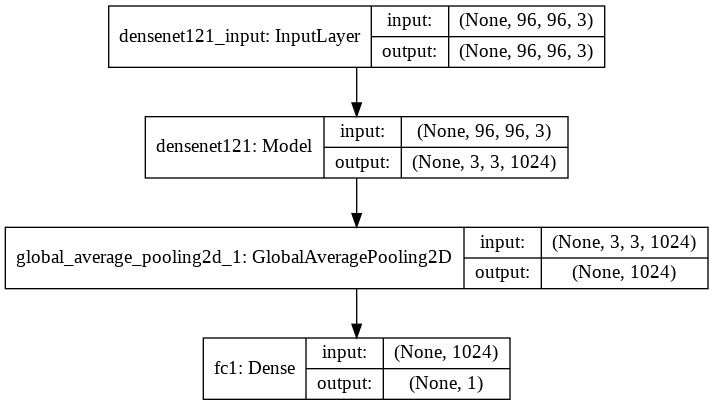

In [0]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

#Compile & run model

In [0]:
# PARAMS
LEARN_RATE = 1e-4   # 1e-3
BATCH_SIZE = 256
EPOCHS = 20

In [0]:
from keras.optimizers import Adam
import keras_metrics as k_metrics

model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=LEARN_RATE),
              metrics = ['binary_accuracy', 
                          k_metrics.binary_precision(), 
                          k_metrics.binary_recall(),
                          k_metrics.binary_f1_score()
                        ])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [0]:
history = model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(x_test, y_test),
          shuffle="batch")


Train on 262144 samples, validate on 32768 samples
Epoch 1/20
262144/262144 [==============================] - 484s 2ms/step - loss: 0.1950 - binary_accuracy: 0.9278 - precision: 0.9342 - recall: 0.9204 - f1_score: 0.9272 - val_loss: 0.3370 - val_binary_accuracy: 0.8576 - val_precision: 0.9289 - val_recall: 0.7743 - val_f1_score: 0.8446
Epoch 2/20
262144/262144 [==============================] - 403s 2ms/step - loss: 0.0789 - binary_accuracy: 0.9744 - precision: 0.9783 - recall: 0.9702 - f1_score: 0.9742 - val_loss: 0.5341 - val_binary_accuracy: 0.7966 - val_precision: 0.9728 - val_recall: 0.6101 - val_f1_score: 0.7499
Epoch 3/20
262144/262144 [==============================] - 400s 2ms/step - loss: 0.0444 - binary_accuracy: 0.9858 - precision: 0.9881 - recall: 0.9836 - f1_score: 0.9858 - val_loss: 0.8253 - val_binary_accuracy: 0.7408 - val_precision: 0.9836 - val_recall: 0.4896 - val_f1_score: 0.6538
Epoch 4/20
262144/262144 [==============================] - 400s 2ms/step - loss: 0.

# Metrics

In [0]:
from matplotlib import pyplot

# Prepare metrics functions
def plot_metrics(code_metrics, name_metrics):
    pyplot.plot(history.history[code_metrics])
    pyplot.plot(history.history['val_' + code_metrics])
    pyplot.title('Model ' + name_metrics)
    pyplot.ylabel(name_metrics)
    pyplot.xlabel('Epoch')
    pyplot.legend(['Train', 'Test'], loc='upper left')
    pyplot.show()

def show_metrics(list_metrics, name_stage, name_model):
    name_metrics = ['accuracy', 'precision', 'recall', 'f1-score']
    for i in range(4):
        print(name_model + ' ' + name_stage + ' ' + 
              name_metrics[i] + ' : ' + str(list_metrics[i + 1] * 100))

In [0]:
prediction = model.predict(x_train)
print(">=0.5 (1): {}".format(np.count_nonzero(prediction >= 0.5)))
print("<0.5 (0): {}".format(np.count_nonzero(prediction < 0.5)))

print("1 in train : {}".format(np.count_nonzero(y_train == 1)))
print("0 in train : {}".format(np.count_nonzero(y_train == 0)))

print(prediction)

>=0.5 (1): 128115
<0.5 (0): 134029
1 in train : 131072
0 in train : 131072
[[0.01146433]
 [0.9999999 ]
 [0.99999946]
 ...
 [0.99999607]
 [0.        ]
 [0.03406227]]


In [0]:
prediction = model.predict(x_test)
print(">=0.5 (1): {}".format(np.count_nonzero(prediction >= 0.5)))
print("<0.5 (0): {}".format(np.count_nonzero(prediction < 0.5)))

print("1 in test : {}".format(np.count_nonzero(y_test == 1)))
print("0 in test : {}".format(np.count_nonzero(y_test == 0)))

print(prediction)

>=0.5 (1): 11972
<0.5 (0): 20796
1 in test : 16377
0 in test : 16391
[[3.2693148e-05]
 [9.9978161e-01]
 [2.7176440e-03]
 ...
 [1.0000000e+00]
 [9.9799877e-01]
 [3.0239820e-03]]


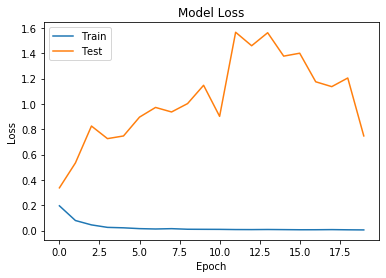

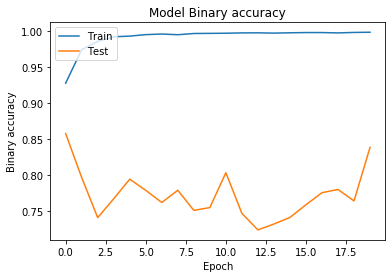

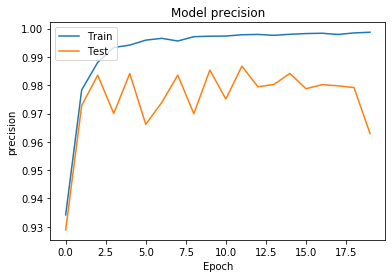

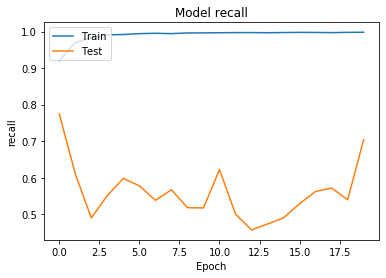

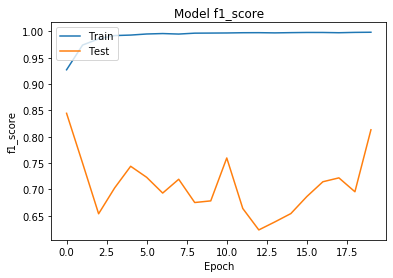

In [0]:
plot_metrics('loss', 'Loss')
plot_metrics('binary_accuracy',  'Binary accuracy')
plot_metrics('precision', 'precision')
plot_metrics('recall', 'recall')
plot_metrics('f1_score',  'f1_score')

In [0]:
name_model = "DensNet121 retrained"
show_metrics(model.evaluate(x_train, y_train), 'train', name_model)
show_metrics(model.evaluate(x_valid, y_valid), 'valid', name_model)
show_metrics(model.evaluate(x_test,  y_test),  'test',  name_model)

262144/262144 [==============================] - 242s 924us/step
DensNet121 retrained train accuracy : 97.67112731933594
DensNet121 retrained train precision : 98.77141630558577
DensNet121 retrained train recall : 96.54312133781697
DensNet121 retrained train f1-score : 97.64455279089698
32768/32768 [==============================] - 32s 965us/step
DensNet121 retrained valid accuracy : 82.733154296875
DensNet121 retrained valid precision : 95.8793797644489
DensNet121 retrained valid recall : 68.37314435782042
DensNet121 retrained valid f1-score : 79.82311759881881
32768/32768 [==============================] - 30s 923us/step
DensNet121 retrained test accuracy : 83.8470458984375
DensNet121 retrained test precision : 96.29134647430428
DensNet121 retrained test recall : 70.3914025763547
DensNet121 retrained test f1-score : 81.32914253275564
